<a href="https://colab.research.google.com/github/2SUBDA/Breakouts/blob/Week8/Week8_MLP_WalkThrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow

     |████████████████████████████████| 195.7 MB 63 kB/s s eta 0:00:01  |█                               | 5.7 MB 7.2 MB/s eta 0:00:27     |█▍                              | 8.5 MB 7.2 MB/s eta 0:00:26     |█████                           | 30.1 MB 37.2 MB/s eta 0:00:05     |█████▉                          | 35.3 MB 37.2 MB/s eta 0:00:05     |█████████                       | 55.4 MB 26.7 MB/s eta 0:00:06     |████████████▍                   | 76.1 MB 1.8 MB/s eta 0:01:06     |█████████████▎                  | 81.5 MB 28.9 MB/s eta 0:00:04     |██████████████                  | 85.5 MB 28.9 MB/s eta 0:00:04     |████████████████▍               | 100.1 MB 35.6 MB/s eta 0:00:03     |████████████████████▍           | 124.8 MB 37.5 MB/s eta 0:00:02     |████████████████████████████▉   | 176.2 MB 47.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 15.0 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py

In [3]:
# BASIC WALK THROUGH FOR FASHION-MNIST NN
# BASED ON KERAS TUTORIALS (2019)
# UPDATED WITH CHANGES TO NEURALNET CLASS

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

import os
import struct
import numpy as np
import pandas

import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# OBTAIN

from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [5]:
# SCRUB
# FLATTEN 28 x 28 IMAGE TO 784 VECTOR
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [6]:
# SCRUB
# NORMALIZE INPUTS FROM RGB COLOR TO 0-1
X_train = X_train / 255
X_test = X_test / 255

In [7]:
# SHUFFLE TRAINING SEQUENCE
# USING RANDOM SEQUENCE FROM NUMPY

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [9]:
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [10]:
# FIRST PASS WITH MLP

import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
      Number of output units, should be equal to the
      number of unique class labels.

    n_features : int
      Number of features (dimensions) in the target dataset.
      Should be equal to the number of columns in the X array.

    n_hidden : int (default: 30)
      Number of hidden units.

    l1 : float (default: 0.0)
      Lambda value for L1-regularization.
      No regularization if l1=0.0 (default)

    l2 : float (default: 0.0)
      Lambda value for L2-regularization.
      No regularization if l2=0.0 (default)

    epochs : int (default: 500)
      Number of passes over the training set.

    eta : float (default: 0.001)
      Learning rate.

    alpha : float (default: 0.0)
      Momentum constant. Factor multiplied with the
      gradient of the previous epoch t-1 to improve
      learning speed
      w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    
    decrease_const : float (default: 0.0)
      Decrease constant. Shrinks the learning rate
      after each epoch via eta / (1 + epoch*decrease_const)

    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent circles.

    minibatches : int (default: 1)
      Divides training data into k minibatches for efficiency.
      Normal gradient descent learning if k=1 (default).

    random_state : int (default: None)
      Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """  
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step"""
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function"""
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation."""
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    # FUNCTION FOR FITTING MLP 
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data"""
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [11]:
#run a neural net. These are the different inputs for the classifier
#defined above. Can take 10, 15, 20, 45 minutes to run 1000
nn = NeuralNetMLP(n_output=10, #number of classes in the data set being examined (ex. for mnist 10 classes because 0,1,2,3,4,5,6,7,8,9). Note: this only works for fully labeled data sets.
                  n_features=X_train.shape[1], 
                  n_hidden=30, #try 30, 50, 80, generally more hidden layers is more accurate
                  l2=0.1, #Regularization cost, adjusting your weights 
                  l1=0.0, #Regularization cost, adjusting your weights 
                  epochs=100, #iterations (backward and forwarded passes)
                  eta=0.001, #learning rate, how fast and slow you go up and down your optimization curve
                  alpha=0.001, #multiplying to improve the speed (weights are multiplied by this alpha). Improving speed of how well your model learns
                  decrease_const=0.00001,#if you made your learning rate too high, it will shrink your learning rate so it doesn't bounce around too much
                  minibatches=50, #chunk up my training data into groups of 50 (speeds up the performance since there are so many)
                  shuffle=True, #for each epoch, it shuffles
                  random_state=1) #set value for making the shuffle

In [12]:
#Time the results of the nn - results in seconds

start = time.time()

nn.fit(X_train, y_train, print_progress=True)

end = time.time()
final_time = end-start

print(final_time)

Epoch: 100/100

121.97658228874207


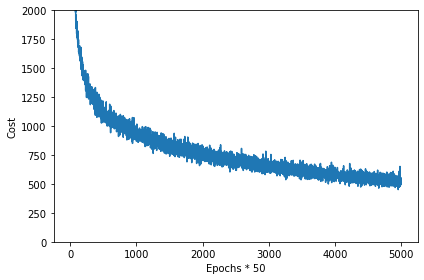

In [13]:
# ROUGH PLOT FOR EACH OF THE 50 BATCH RUNS

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

In [14]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

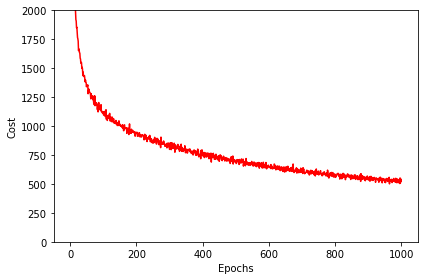

In [15]:
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

In [16]:
#see how we did on accuracy for training and test set.
#want these to be higher than 97 and 96.
import sys

y_train_pred = nn.predict(X_train)

if sys.version_info < (3, 0):
    acc = (np.sum(y_train == y_train_pred, axis=0)).astype('float') / X_train.shape[0]
else:
    acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 96.51%


In [17]:
y_test_pred = nn.predict(X_test)

if sys.version_info < (3, 0):
    acc = (np.sum(y_test == y_test_pred, axis=0)).astype('float') / X_test.shape[0]
else:
    acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 95.61%


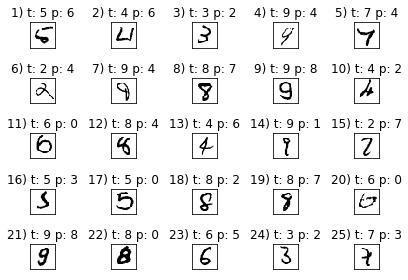

In [18]:
#look at places we might have missed

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

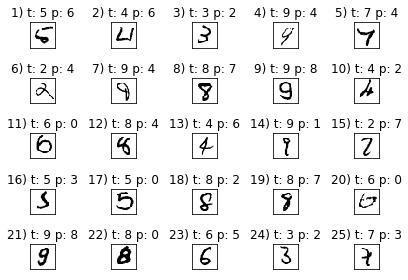

In [19]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

In [28]:
miscl_img = X_test[y_test != y_test_pred][50:75]
correct_lab = y_test[y_test != y_test_pred][50:75]
miscl_lab= y_test_pred[y_test != y_test_pred][50:75]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

SyntaxError: invalid syntax (<ipython-input-28-f0611c597e3b>, line 2)